#Import Packages & Dataset

In [33]:
#PIP
!pip install shap
!pip install graphviz
!pip install lime

#SKlearn
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score,f1_score,confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors


#Explanabilty and Models
import lime
import lime.lime_tabular
import shap
import xgboost as xgb

#Others
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import drive

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
apache = pd.read_csv('/content/drive/MyDrive/Medical Prediction/training_v2.csv')
pred_apache=apache['apache_4a_hospital_death_prob']
y_apache = apache['hospital_death']

In [36]:
# Load example dataset
df_mice = pd.read_csv('/content/drive/MyDrive/Medical Prediction/Multiple_Imputation_using_miceforest.csv')
df_clean = pd.read_csv('/content/drive/MyDrive/Medical Prediction/final_df_clean.csv')

#Helper Functions

In [53]:
def get_scores(y, pred, threshold=0.5):
    # Calculate AUC
    auc_score = roc_auc_score(y, pred)
    print("AUC Score:", auc_score)

    # Convert probabilities to binary predictions using a threshold
    predictions = [1 if p >= threshold else 0 for p in pred]

    # Calculate PPV (Positive Predictive Value)
    ppv = precision_score(y, predictions)
    print("PPV (Positive Predictive Value):", ppv)

    # Calculate Sensitivity (Recall)
    sensitivity = recall_score(y, predictions)
    print("Sensitivity (Recall):", sensitivity)

    # Calculate NPV (Negative Predictive Value)
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    npv = tn / (tn + fn) if (tn + fn) != 0 else None  # Handling division by zero
    print("NPV (Negative Predictive Value):", npv)

    # Calculate Specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else None  # Handling division by zero
    print("Specificity:", specificity)

    # Calculate F1 score
    f1 = f1_score(y, predictions)
    print("F1 Score:", f1)


In [40]:
# Function to plot pie chart
def plot_pie_chart(data, title):
    labels = [x[0] for x in data]
    values = [abs(x[1]) for x in data]  # Use absolute values for pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Define custom colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#66c2ff', '#99ffcc', '#ff9966']

#Apache

In [57]:
# Find indices where NaN values exist in either column
nan_indices = np.isnan(pred_apache) | np.isnan(y_apache)

# Drop rows with NaN values
pred_apache = pred_apache[~nan_indices]
y_1 = y_apache[~nan_indices]

In [58]:
get_scores(y_1,pred_apache)

AUC Score: 0.8407329772700795
PPV (Positive Predictive Value): 0.5536591068505962
Sensitivity (Recall): 0.32160804020100503
NPV (Negative Predictive Value): 0.93716111663249
Specificity: 0.9750140701281363
F1 Score: 0.406872852233677


#Clean Dataset

In [82]:
# Separate the target
y = df_clean['hospital_death']
# Drop the target
X = df_clean.drop(columns=['hospital_death'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Logistic Regression**

In [83]:
# Start the timer
start_time = time.time()

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

# Predict probabilities for the test set
pred_probabilities = logistic_model.predict_proba(X_test)
# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]
get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 0.43001556396484375 seconds
AUC Score: 0.8379742532760613
PPV (Positive Predictive Value): 0.6126272912423625
Sensitivity (Recall): 0.9477000630119723
NPV (Negative Predictive Value): 0.8821022727272727
Specificity: 0.3950381679389313
F1 Score: 0.7441860465116279


X does not have valid feature names, but LogisticRegression was fitted with feature names


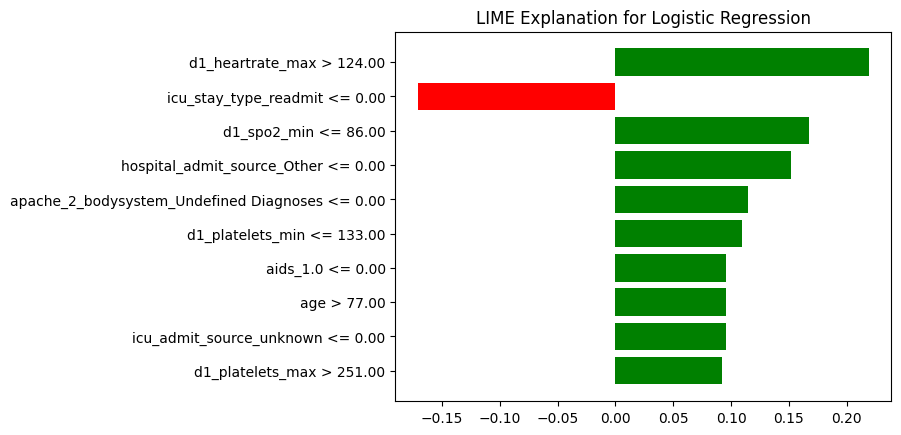

In [84]:
# Create LIME explainer for logistic regression model
logistic_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns)

# Generate explanation for logistic regression model
logistic_exp = logistic_explainer.explain_instance(X_test.values[0], logistic_model.predict_proba)

# Visualize explanations for logistic regression model
logistic_exp.as_pyplot_figure()
plt.title('LIME Explanation for Logistic Regression')
plt.show()

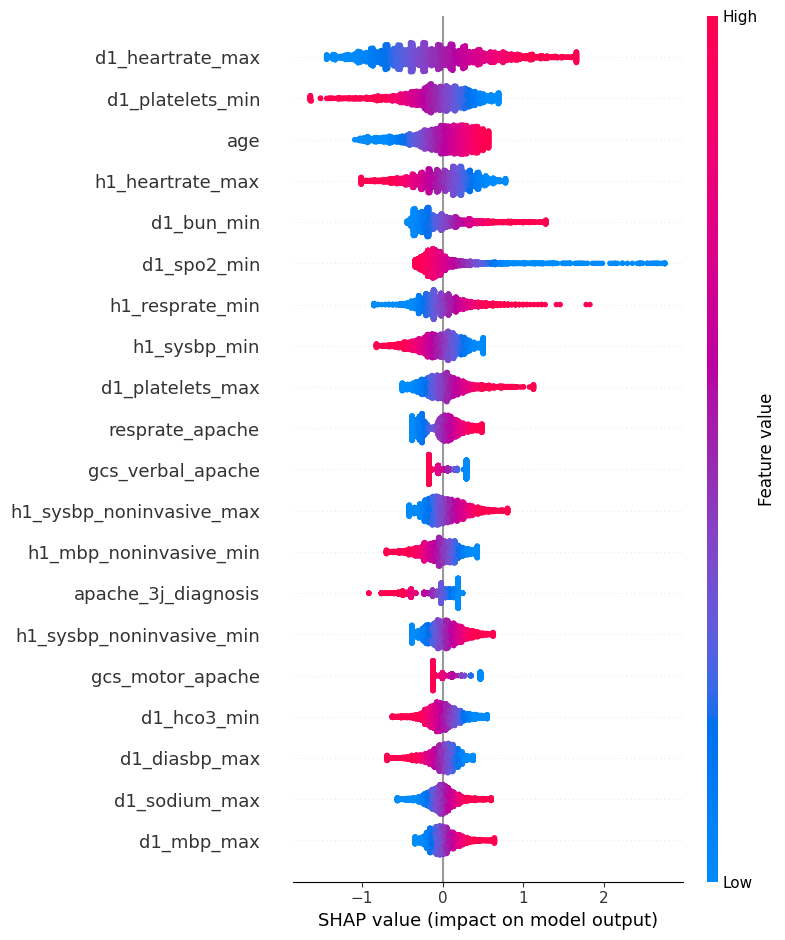

In [85]:
# Create SHAP explainer
explainer = shap.Explainer(logistic_model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

[('d1_heartrate_min', 0.013661779558372751), ('h1_heartrate_max', 0.013727574024159738), ('h1_diasbp_max', 0.013732538973332225), ('d1_platelets_max', 0.015521855701727738), ('d1_diasbp_noninvasive_min', 0.017038206817260527), ('h1_sysbp_noninvasive_min', 0.023371907591770026), ('age', 0.0287267279926989), ('h1_diasbp_min', 0.030427647881556153), ('h1_sysbp_noninvasive_max', 0.03371377767711887), ('d1_spo2_min', 0.045644001173889864)]


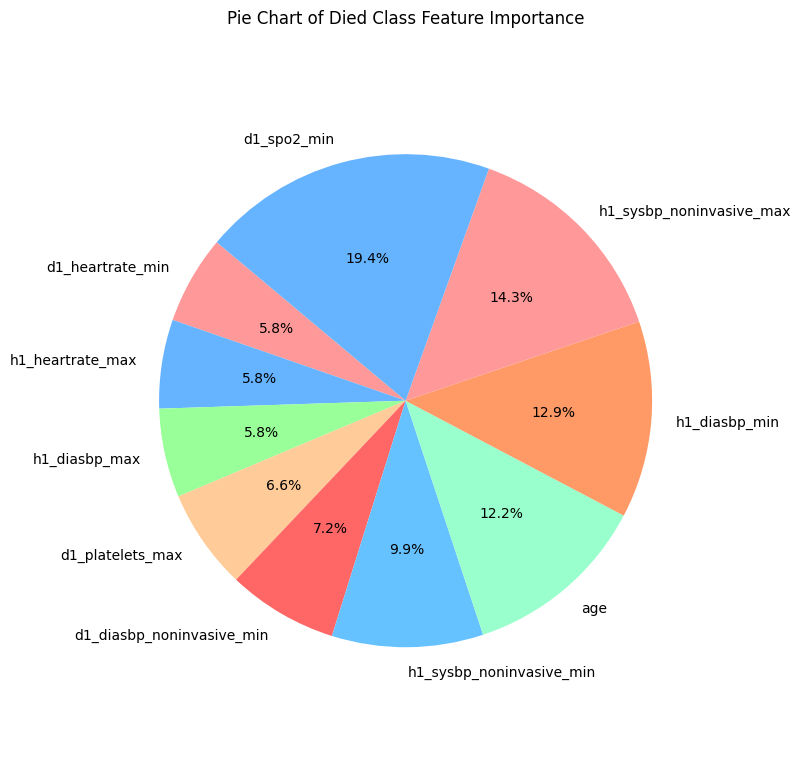

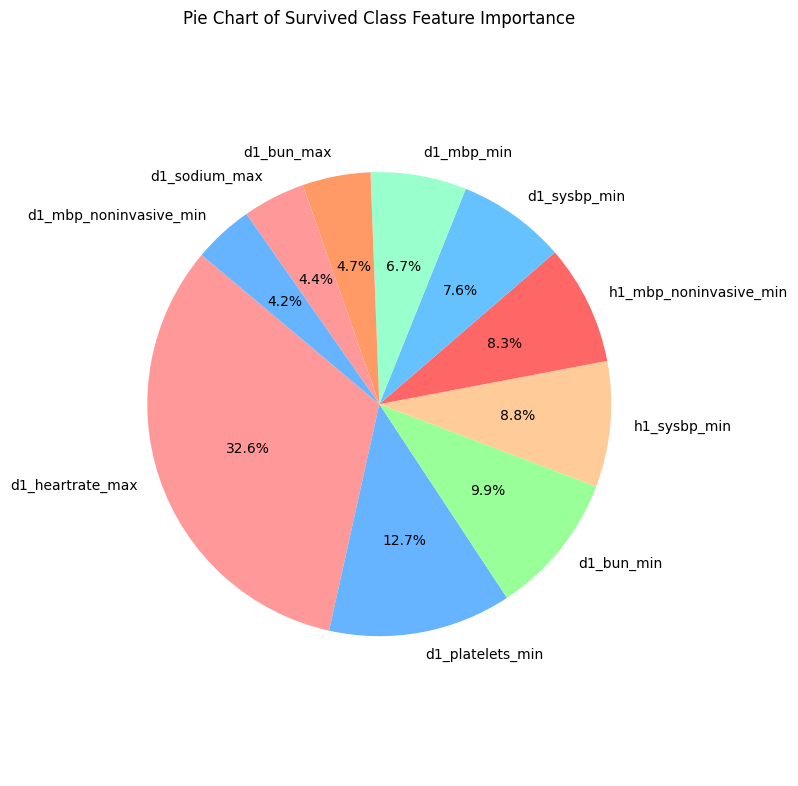

In [86]:
# Get feature names
feature_names = X.columns

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values, axis=0)

# Create a list to store feature names and their mean SHAP values
result_list = list(zip(feature_names, mean_shap_values))
result_list = [(x[0],x[1].mean()) for x in result_list]
result_list = sorted(result_list, key=lambda x: x[1])
neg_list =result_list[:10]
pos_list =result_list[-10:]

# Separate positive and negative values
positive_values = [(label, value) for label, value in pos_list if value > 0 and value < 0.3] #threshold=0.1
negative_values = [(label, value) for label, value in neg_list if value < 0 and value >-0.3] #threshold=-0.1
print(positive_values)
# Plot pie charts
plot_pie_chart(positive_values, 'Pie Chart of Died Class Feature Importance')
plot_pie_chart(negative_values, 'Pie Chart of Survived Class Feature Importance')

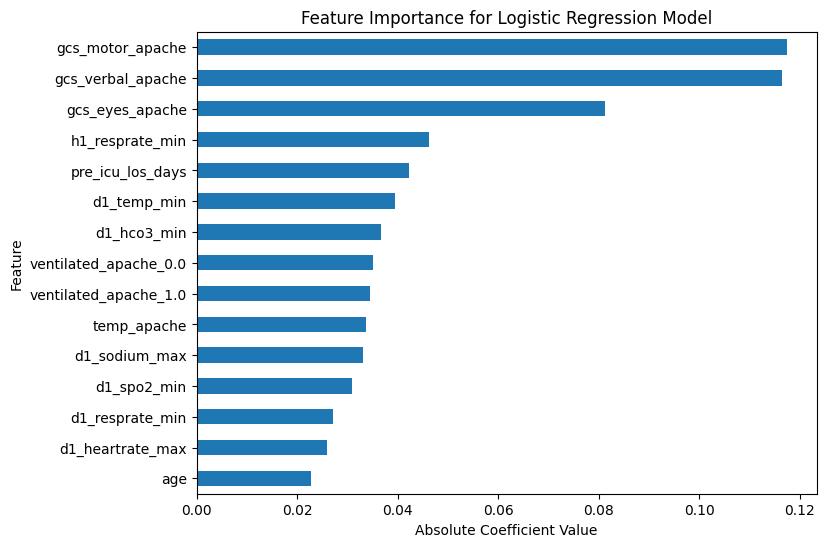

In [87]:
# Extracting coefficients from the model
coefficients = logistic_model.coef_[0]

# Creating a Series with feature coefficients
feature_importances = pd.Series(coefficients, index=X.columns)

# Extracting the most important first 15 features
sub_feature_importances = feature_importances.abs().nlargest(15)  # Taking absolute values for sorting

# Plotting the feature importances
sub_feature_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression Model')
plt.show()

**XGB**

In [88]:
# Now train your XGBoost model with X_processed and y
# Start the timer
start_time = time.time()

# Train XGBoost model
xgb_model = xgb.XGBClassifier(enable_categorical=True)
xgb_model.fit(X_train, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

# Predict probabilities for the test set
pred_probabilities = xgb_model.predict_proba(X_test)

# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]
get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 2.534968614578247 seconds
AUC Score: 0.876648853358474
PPV (Positive Predictive Value): 0.7032540067994172
Sensitivity (Recall): 0.9124133585381222
NPV (Negative Predictive Value): 0.8736363636363637
Specificity: 0.611323155216285
F1 Score: 0.7942951179374657


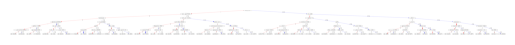

In [89]:
xgb.plot_tree(xgb_model, num_trees=0)
plt.savefig('xgb_tree_miceforest', dpi=3000)

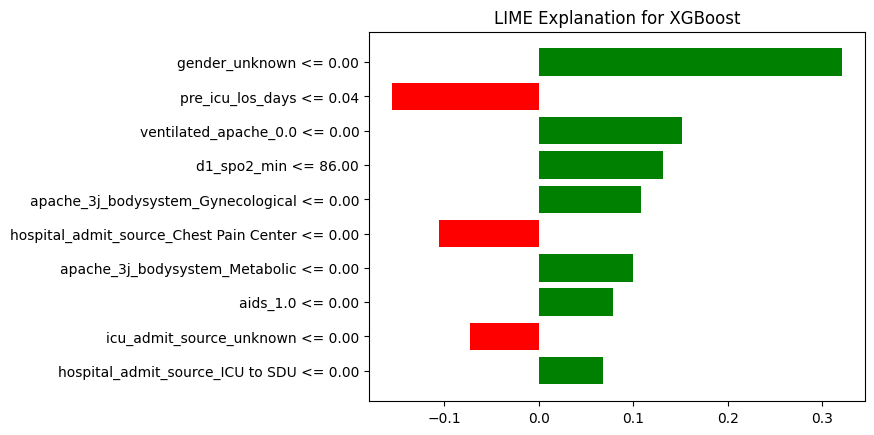

In [90]:
# Create LIME explainer for logistic regression model
xgb_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns)

# Generate explanation for logistic regression model
xgb_exp = logistic_explainer.explain_instance(X_test.values[1], xgb_model.predict_proba)

# Visualize explanations for logistic regression model
xgb_exp.as_pyplot_figure()
plt.title('LIME Explanation for XGBoost')
plt.show()

In [91]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Get feature names
feature_names = X_test.columns

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values, axis=0)

# Create a list to store feature names and their mean SHAP values
result_list = [(feature_names[i], mean_shap_values[i].mean()) for i in range(len(feature_names))]
result_list = sorted(result_list, key=lambda x: x[1])
neg_list =result_list[:10]
pos_list =result_list[-10:]
print(neg_list)

[('age', -0.04384351), ('h1_mbp_noninvasive_min', -0.019681506), ('icu_admit_source_Operating Room / Recovery', -0.016857592), ('h1_sysbp_noninvasive_max', -0.014418498), ('apache_3j_bodysystem_Metabolic', -0.0139128035), ('hematocrit_apache', -0.013640577), ('pre_icu_los_days', -0.011485371), ('heart_rate_apache', -0.011353796), ('h1_mbp_max', -0.011259529), ('d1_resprate_min', -0.011111427)]


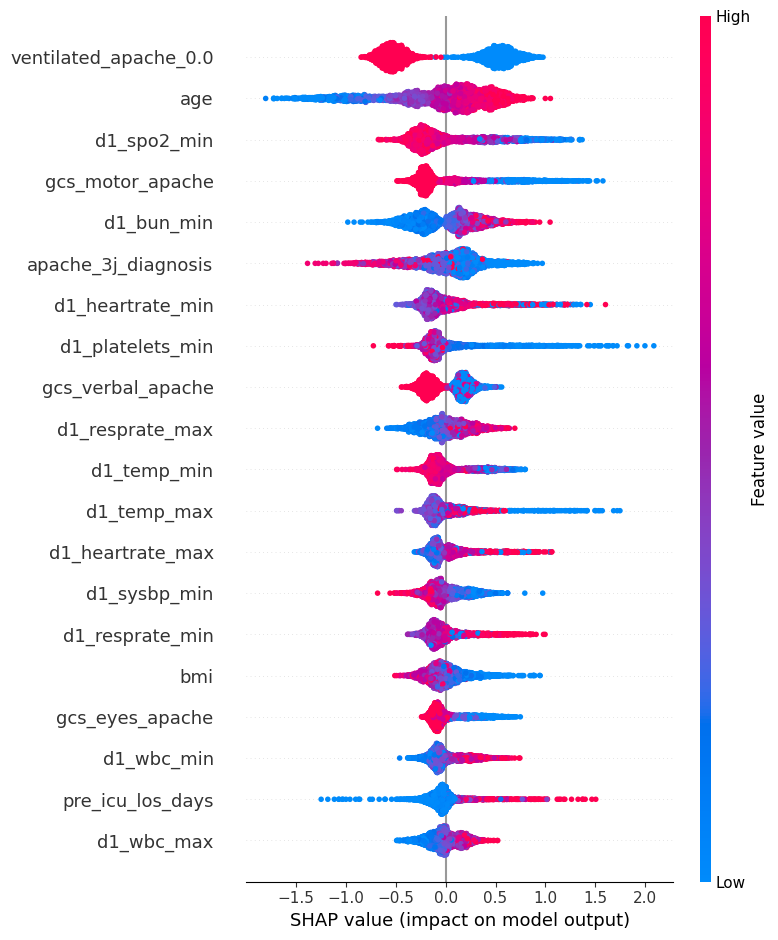

In [92]:
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

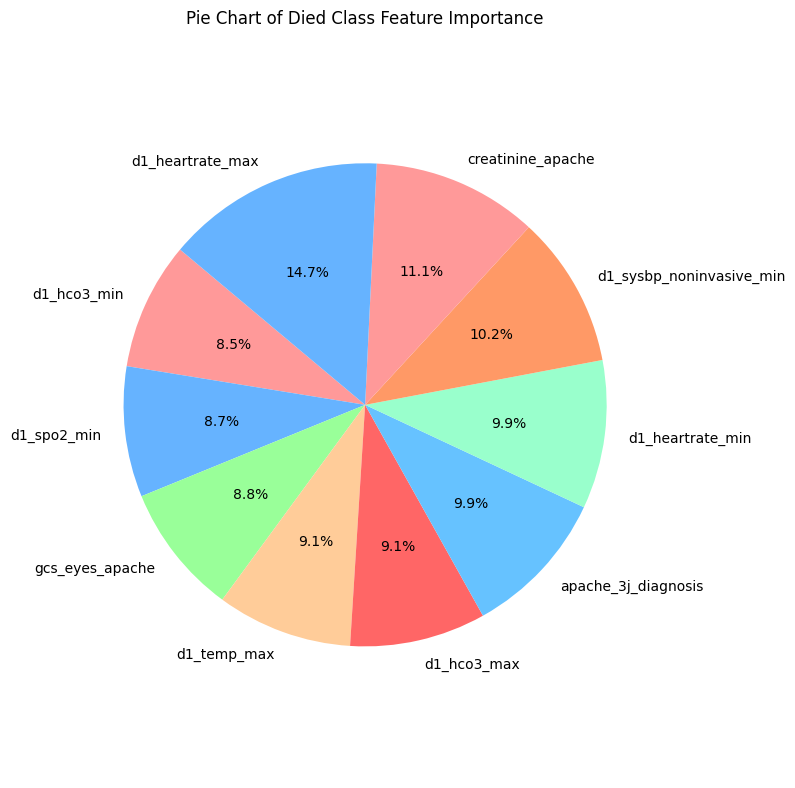

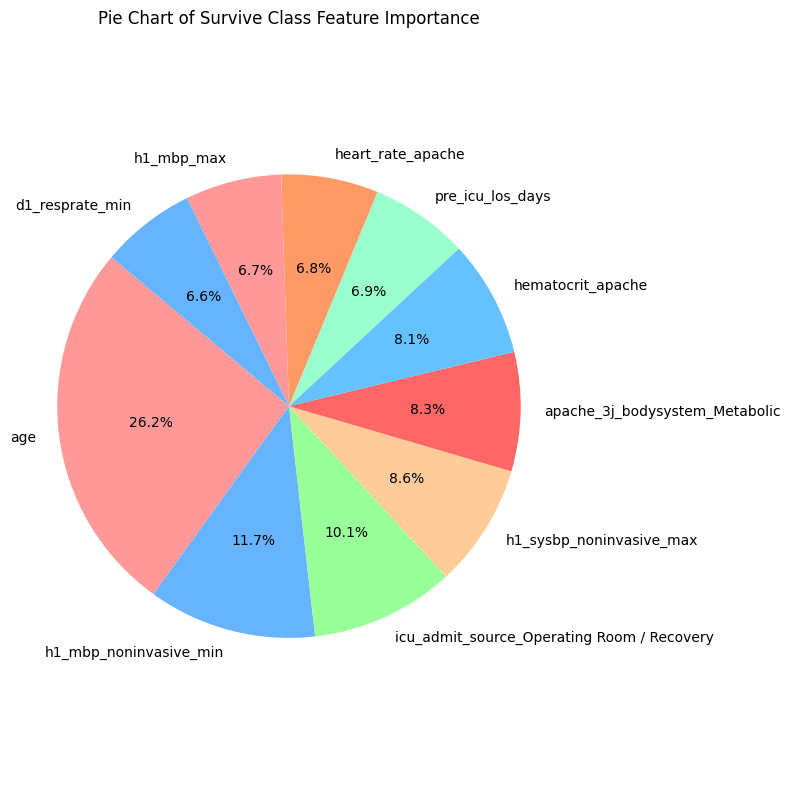

In [93]:
# Separate positive and negative values
positive_values = [(label, value) for label, value in pos_list if value > 0 and value < 0.95] #threshold=0.95
negative_values = [(label, value) for label, value in neg_list if value < 0 and value >-0.95] #threshold=-0.95

# Plot pie charts
plot_pie_chart(positive_values, 'Pie Chart of Died Class Feature Importance')
plot_pie_chart(negative_values, 'Pie Chart of Survive Class Feature Importance')

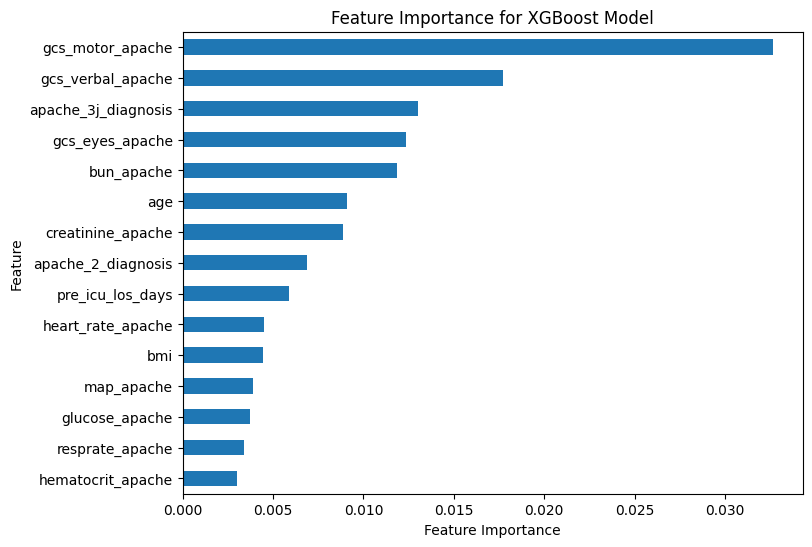

In [94]:
# Extracting feature importances from the model
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Extracting the most important first 15 features
sub_feature_importances = feature_importances[:15]

# Sorting the feature importances
sub_feature_importances.sort_values(inplace=True)

# Plotting the feature importances
sub_feature_importances.plot(kind='barh', figsize=(8,6))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost Model')
plt.show()

**KNN**

In [95]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Define the range of k values to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}  # Example values, adjust as needed

# Initialize the KNN classifier
knn_model = KNeighborsClassifier()

# Perform grid search to find the best value of k
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
start_time = time.time()
grid_search.fit(X_scaled, y_train)
training_time = time.time() - start_time

# Get the best k value and its corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

print("Best k:", best_k)
print("Best Accuracy:", best_accuracy)

Best k: 15
Best Accuracy: 0.7361667702197111


In [96]:
# Start the timer
start_time = time.time()

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_scaled, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")
X_scaled_test = scaler.fit_transform(X_test)
# Predict probabilities for the test set
pred_probabilities = knn_model.predict_proba(X_scaled_test)

# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]

get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 0.018839120864868164 seconds
AUC Score: 0.8343931530196844
PPV (Positive Predictive Value): 0.6559819413092551
Sensitivity (Recall): 0.9155639571518589
NPV (Negative Predictive Value): 0.8580508474576272
Specificity: 0.5152671755725191
F1 Score: 0.7643345607574962


#Mice Dataset

In [59]:
# Separate the target
y = df_mice['hospital_death']
# Drop the target
X = df_mice.drop(columns=['hospital_death'])

categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Logistic Regression**

In [60]:
# Start the timer
start_time = time.time()

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

# Predict probabilities for the test set
pred_probabilities = logistic_model.predict_proba(X_test)
# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]
get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 6.575756072998047 seconds
AUC Score: 0.7547648197344652
PPV (Positive Predictive Value): 0.31004110393423373
Sensitivity (Recall): 0.332703213610586
NPV (Negative Predictive Value): 0.936358173076923
Specificity: 0.9298758653616614
F1 Score: 0.3209726443768997


X does not have valid feature names, but LogisticRegression was fitted with feature names


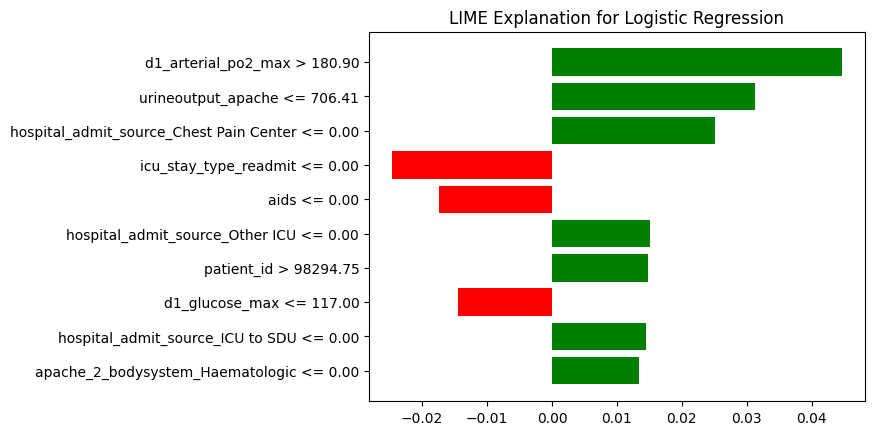

In [61]:
# Create LIME explainer for logistic regression model
logistic_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns)

# Generate explanation for logistic regression model
logistic_exp = logistic_explainer.explain_instance(X_test.values[0], logistic_model.predict_proba)

# Visualize explanations for logistic regression model
logistic_exp.as_pyplot_figure()
plt.title('LIME Explanation for Logistic Regression')
plt.show()

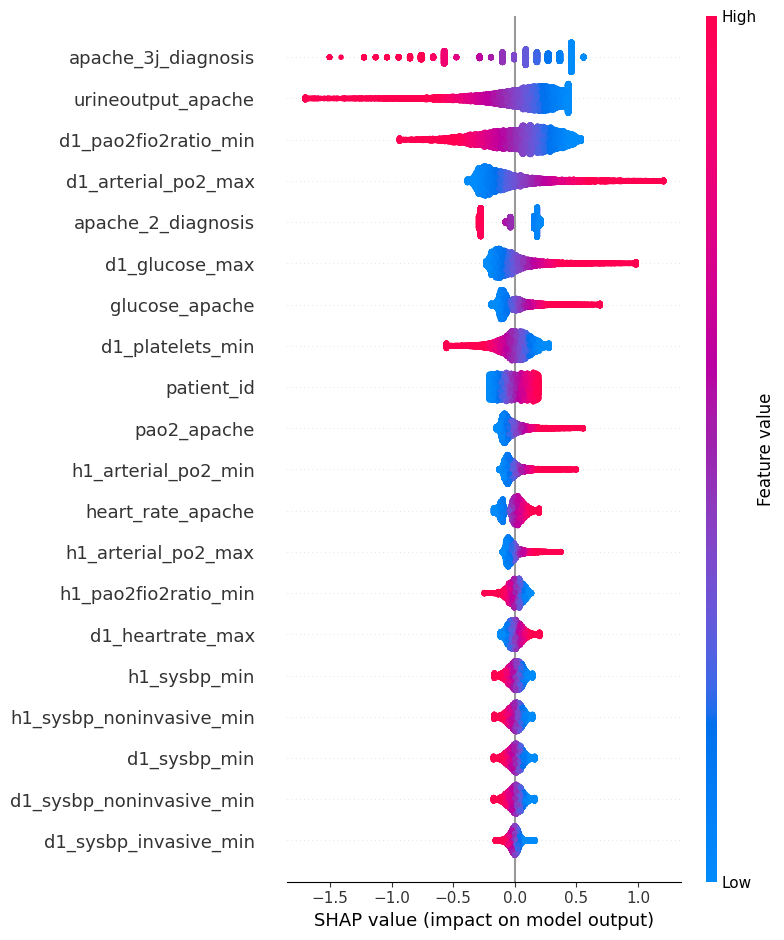

In [62]:
# Create SHAP explainer
explainer = shap.Explainer(logistic_model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

[('d1_sysbp_min', 0.004281277601063273), ('h1_sysbp_min', 0.004948854429419539), ('h1_sysbp_noninvasive_min', 0.005089786100511079), ('bun_apache', 0.005539639019644989), ('h1_pao2fio2ratio_min', 0.005668974559450286), ('d1_bun_max', 0.00570224374696357), ('apache_2_diagnosis', 0.00820166836955672), ('urineoutput_apache', 0.02239271621005401), ('d1_pao2fio2ratio_min', 0.033829326070983524), ('apache_3j_diagnosis', 0.04421483577269128)]


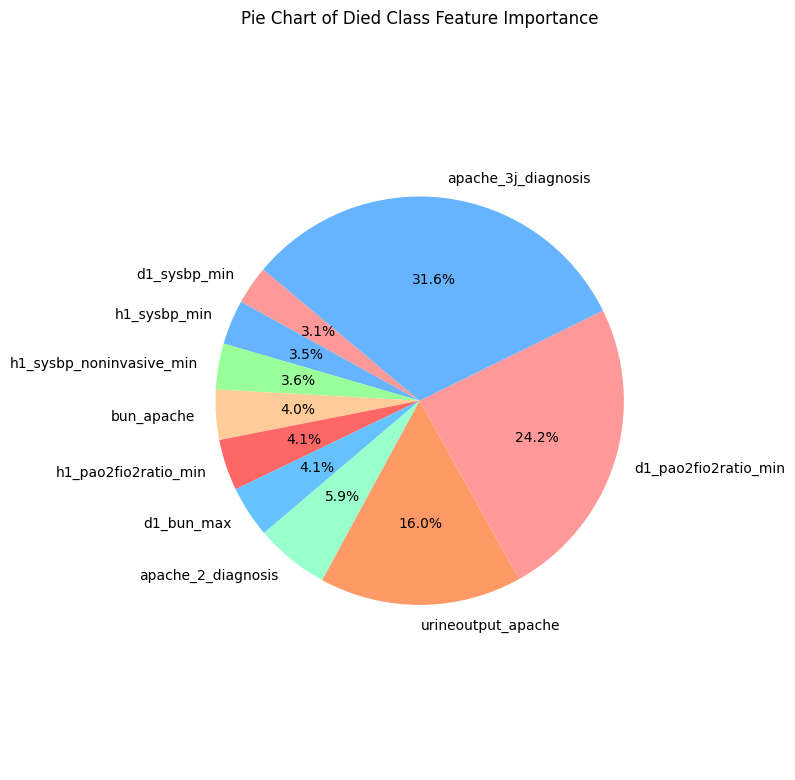

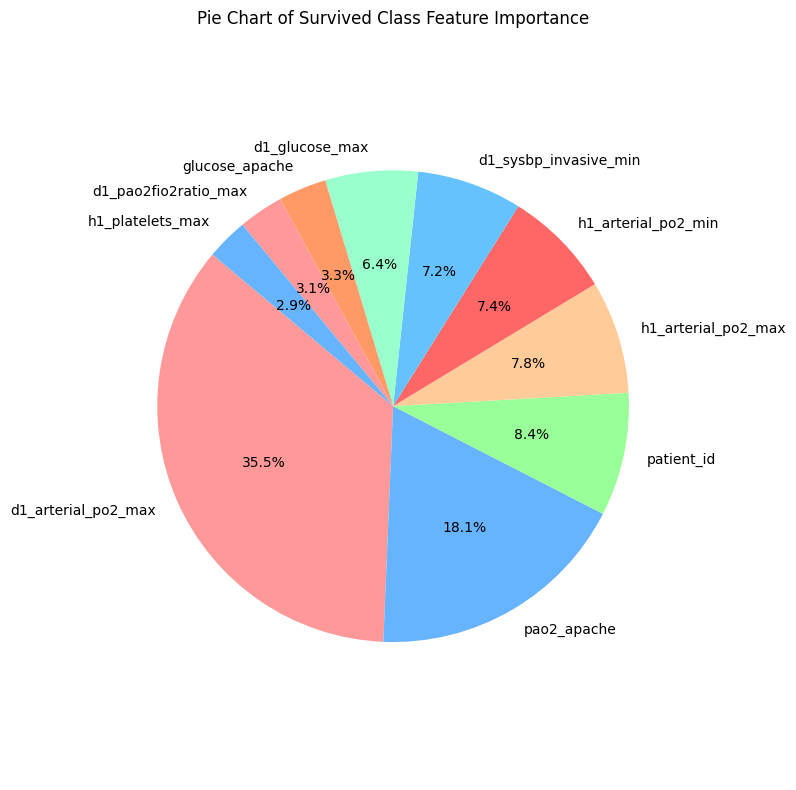

In [63]:
# Get feature names
feature_names = X.columns

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values, axis=0)

# Create a list to store feature names and their mean SHAP values
result_list = list(zip(feature_names, mean_shap_values))
result_list = [(x[0],x[1].mean()) for x in result_list]
result_list = sorted(result_list, key=lambda x: x[1])
neg_list =result_list[:10]
pos_list =result_list[-10:]

# Separate positive and negative values
positive_values = [(label, value) for label, value in pos_list if value > 0 and value < 0.3] #threshold=0.1
negative_values = [(label, value) for label, value in neg_list if value < 0 and value >-0.3] #threshold=-0.1
print(positive_values)
# Plot pie charts
plot_pie_chart(positive_values, 'Pie Chart of Died Class Feature Importance')
plot_pie_chart(negative_values, 'Pie Chart of Survived Class Feature Importance')

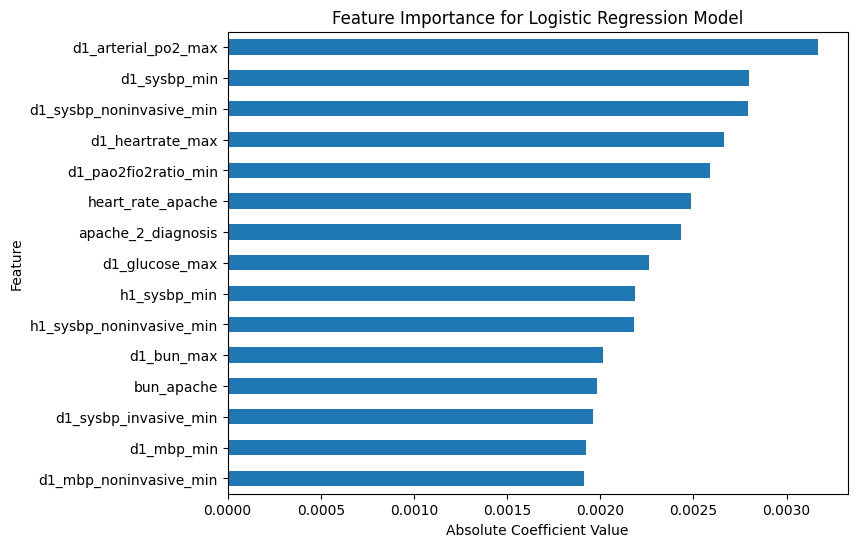

In [64]:
# Extracting coefficients from the model
coefficients = logistic_model.coef_[0]

# Creating a Series with feature coefficients
feature_importances = pd.Series(coefficients, index=X.columns)

# Extracting the most important first 15 features
sub_feature_importances = feature_importances.abs().nlargest(15)  # Taking absolute values for sorting

# Plotting the feature importances
sub_feature_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression Model')
plt.show()

**XGB**

In [75]:
# Now train your XGBoost model with X_processed and y
# Start the timer
start_time = time.time()

# Train XGBoost model
xgb_model = xgb.XGBClassifier(enable_categorical=True)
xgb_model.fit(X_train, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

# Predict probabilities for the test set
pred_probabilities = xgb_model.predict_proba(X_test)

# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]
get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 11.227169275283813 seconds
AUC Score: 0.8890089761599942
PPV (Positive Predictive Value): 0.4506393861892583
Sensitivity (Recall): 0.5551354757403907
NPV (Negative Predictive Value): 0.9569196973395168
Specificity: 0.9359035569348293
F1 Score: 0.49745906267645396


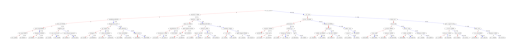

In [76]:
xgb.plot_tree(xgb_model, num_trees=0)
plt.savefig('xgb_tree_miceforest', dpi=3000)

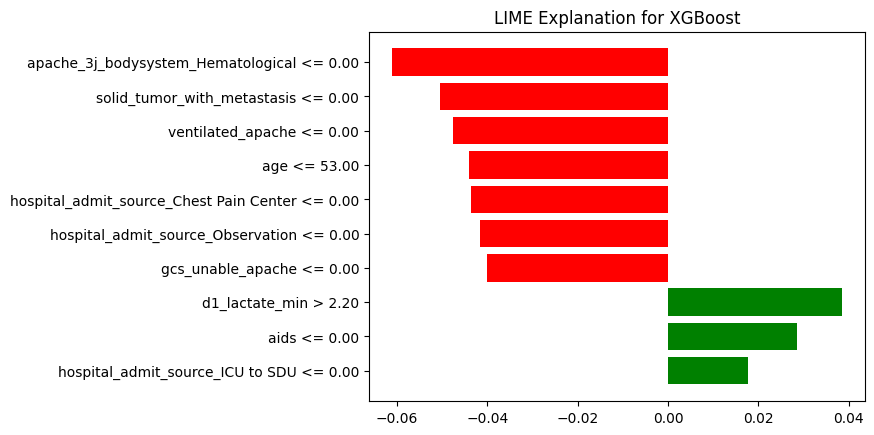

In [77]:
# Create LIME explainer for logistic regression model
xgb_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns)

# Generate explanation for logistic regression model
xgb_exp = logistic_explainer.explain_instance(X_test.values[1], xgb_model.predict_proba)

# Visualize explanations for logistic regression model
xgb_exp.as_pyplot_figure()
plt.title('LIME Explanation for XGBoost')
plt.show()

In [78]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Get feature names
feature_names = X.columns

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values, axis=0)

# Create a list to store feature names and their mean SHAP values
result_list = [(feature_names[i], mean_shap_values[i].mean()) for i in range(len(feature_names))]
result_list = sorted(result_list, key=lambda x: x[1])
neg_list =result_list[:10]
pos_list =result_list[-10:]
print(neg_list)

[('ventilated_apache', -0.09367252), ('age', -0.08530804), ('d1_spo2_min', -0.05591741), ('d1_lactate_min', -0.05174253), ('gcs_verbal_apache', -0.048872206), ('urineoutput_apache', -0.047522902), ('gcs_eyes_apache', -0.03967481), ('d1_heartrate_max', -0.038122576), ('apache_3j_diagnosis', -0.036761906), ('gcs_motor_apache', -0.03612722)]


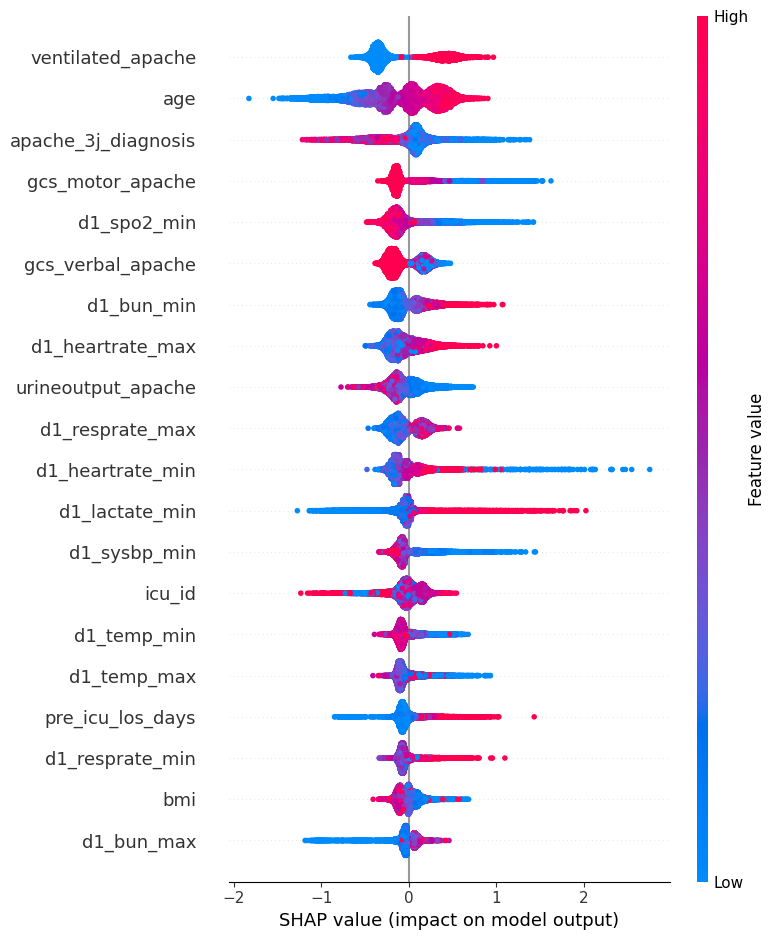

In [79]:
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

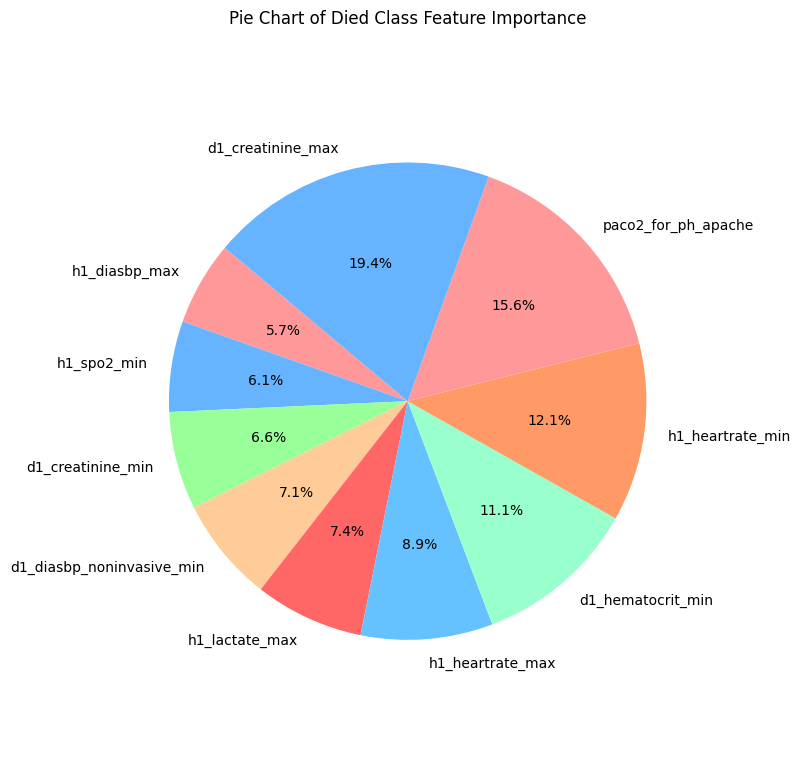

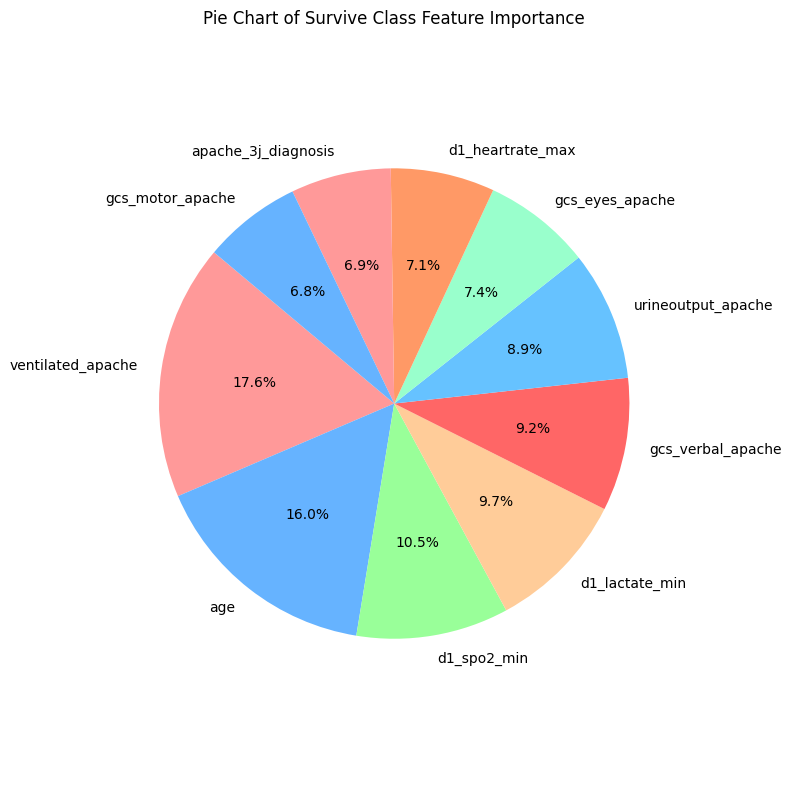

In [80]:
# Separate positive and negative values
positive_values = [(label, value) for label, value in pos_list if value > 0 and value < 0.95] #threshold=0.95
negative_values = [(label, value) for label, value in neg_list if value < 0 and value >-0.95] #threshold=-0.95

# Plot pie charts
plot_pie_chart(positive_values, 'Pie Chart of Died Class Feature Importance')
plot_pie_chart(negative_values, 'Pie Chart of Survive Class Feature Importance')

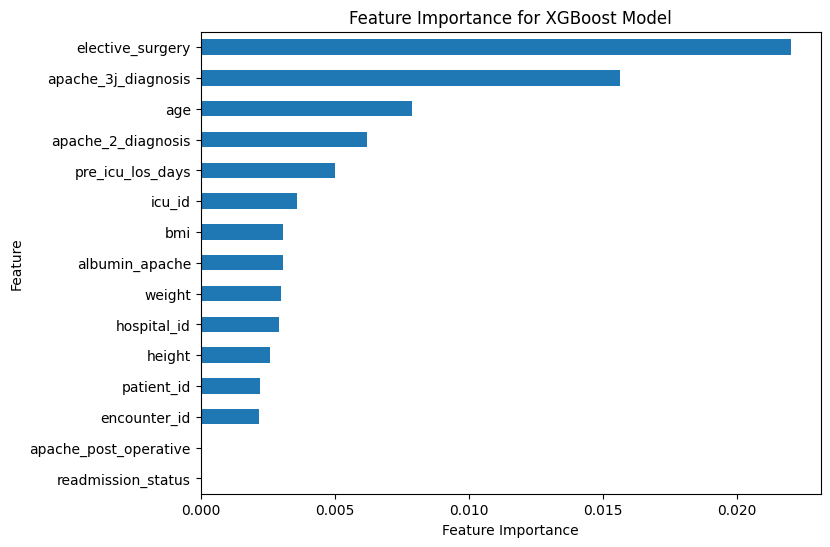

In [81]:
# Extracting feature importances from the model
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Extracting the most important first 15 features
sub_feature_importances = feature_importances[:15]

# Sorting the feature importances
sub_feature_importances.sort_values(inplace=True)

# Plotting the feature importances
sub_feature_importances.plot(kind='barh', figsize=(8,6))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost Model')
plt.show()

**KNN**

In [68]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Define the range of k values to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}  # Example values, adjust as needed

# Initialize the KNN classifier
knn_model = KNeighborsClassifier()

# Perform grid search to find the best value of k
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
start_time = time.time()
grid_search.fit(X_scaled, y_train)
training_time = time.time() - start_time

# Get the best k value and its corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

print("Best k:", best_k)
print("Best Accuracy:", best_accuracy)

Best k: 7
Best Accuracy: 0.9201035845713506


In [69]:
# Start the timer
start_time = time.time()

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_scaled, y_train)

# End the timer
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")
X_scaled_test = scaler.fit_transform(X_test)
# Predict probabilities for the test set
pred_probabilities = knn_model.predict_proba(X_scaled_test)

# Extract probabilities of the positive class (class 1)
pred_probabilities_positive_class = pred_probabilities[:, 1]

get_scores(y_test,pred_probabilities_positive_class,0.2)

Training Time: 0.08928275108337402 seconds
AUC Score: 0.7167297839346697
PPV (Positive Predictive Value): 0.4535211267605634
Sensitivity (Recall): 0.30434782608695654
NPV (Negative Predictive Value): 0.9361037157078366
Specificity: 0.9652661733110528
F1 Score: 0.36425339366515835
